In [ ]:
# Importing the Libraries

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model


In [ ]:
# Get the Dataset

from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['data.csv']))

Saving data.csv to data.csv


In [ ]:
# Print the shape of Dataframe and Check for Null Values
print("Dataframe Shape: ", df.shape)
print("Null Value Present: ", df.isnull().values.any())
if df.isnull().values.any() == True:
  print('The number of missing values is ', df.isnull().sum().sum())

Dataframe Shape:  (5028, 15)
Null Value Present:  False


In [ ]:
print(df)

            Date        LOW       HIGH  ...    ewretd    ewretx    sprtrn
0     2000-01-03  101.68750  112.50000  ...  0.002878  0.002860 -0.009549
1     2000-01-04  101.18750  110.62500  ... -0.017465 -0.017486 -0.038345
2     2000-01-05  103.00000  110.56250  ...  0.007821  0.007743  0.001922
3     2000-01-06   95.00000  107.00000  ...  0.004504  0.004453  0.000956
4     2000-01-07   95.50000  101.00000  ...  0.017008  0.016991  0.027090
...          ...        ...        ...  ...       ...       ...       ...
5023  2019-12-24  282.91971  284.89001  ...  0.003556  0.003383 -0.000195
5024  2019-12-26  284.70001  289.98001  ...  0.003437  0.003367  0.005128
5025  2019-12-27  288.12000  293.97000  ... -0.002284 -0.002529  0.000034
5026  2019-12-30  285.22000  292.69000  ... -0.001236 -0.001732 -0.005781
5027  2019-12-31  289.51999  293.67999  ...  0.005045  0.005000  0.002946

[5028 rows x 15 columns]


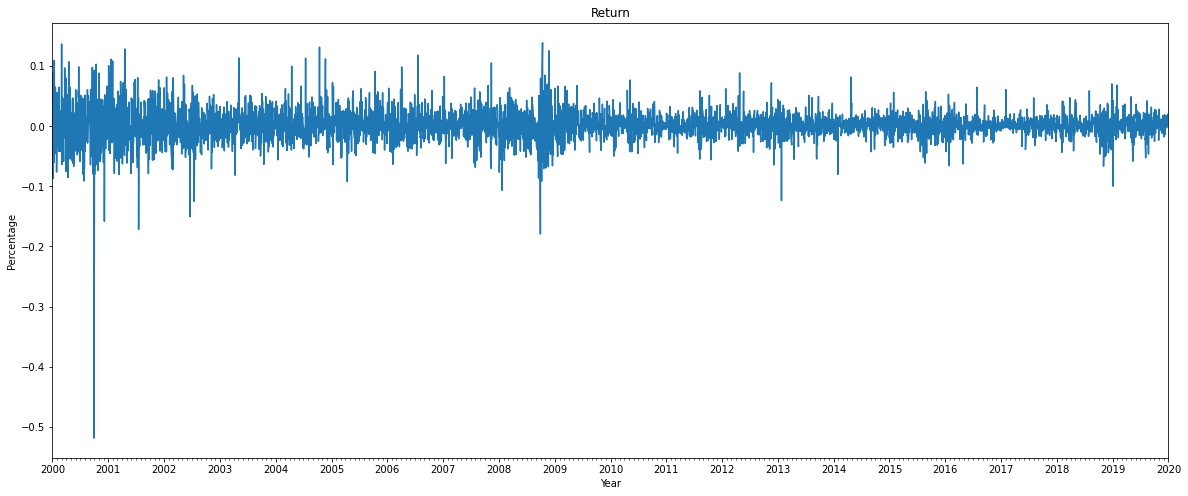

In [ ]:
# Plot the Return
import datetime
import matplotlib.dates as mdates

df['Date'] = pd.to_datetime(df['Date'])

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(df['Date'], df['RET'])

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(df['Date'].min().year, 1, 1)
datemax = datetime.date(df['Date'].max().year + 1, 1, 1)
ax.set_xlim(datemin, datemax)
#ax.set_ylim(-0.2, 0.2)
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.set_title('Return')
plt.show()

In [ ]:
# Set Target Variable
output_var = pd.DataFrame(df['RET'])

# Randomly Select 2 features
df_feature = df.drop(['Date', 'RET'], axis=1)
fea = df_feature.columns

# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
# generate some integers
features = []
for _ in range(2):
  value = randint(0, len(fea)-1)
  feature = fea[value]
  features.append(feature)

df_fea = df[features]
print("The randomly selected features are ", features)

The randomly selected features are  ['PRICE', 'vwretx']


In [ ]:
# Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df_fea)
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()


,PRICE,vwretx
0,0.143426,0.405793
1,0.129728,0.245266
2,0.131905,0.434124
3,0.118842,0.402194
4,0.125374,0.597845


In [ ]:
# Splitting to Training set and Test set
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
  X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
  y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()


In [ ]:
# Process the Data for LSTM
train_X = np.array(X_train)
test_X = np.array(X_test)
X_train = train_X.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = test_X.reshape(X_test.shape[0], 1, X_test.shape[1])


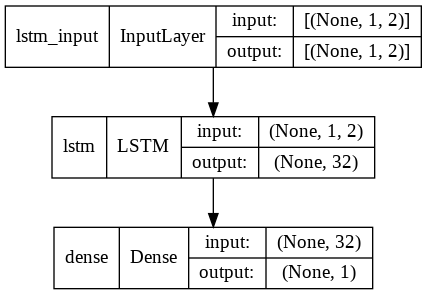

In [ ]:
# Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, train_X.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)


In [ ]:
# Model Training
import timeit
start = timeit.default_timer()

history=lstm.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1, shuffle=False)

stop = timeit.default_timer()


Epoch 1/50
572/572 [==============================] - 3s 3ms/step - loss: 5.9275e-04
Epoch 2/50
572/572 [==============================] - 2s 3ms/step - loss: 5.2726e-04
Epoch 3/50
572/572 [==============================] - 1s 2ms/step - loss: 5.1112e-04
Epoch 4/50
572/572 [==============================] - 1s 2ms/step - loss: 5.0652e-04
Epoch 5/50
572/572 [==============================] - 1s 2ms/step - loss: 5.0485e-04
Epoch 6/50
572/572 [==============================] - 1s 2ms/step - loss: 5.0397e-04
Epoch 7/50
572/572 [==============================] - 1s 2ms/step - loss: 5.0317e-04
Epoch 8/50
572/572 [==============================] - 1s 2ms/step - loss: 5.0268e-04
Epoch 9/50
572/572 [==============================] - 1s 2ms/step - loss: 5.0207e-04
Epoch 10/50
572/572 [==============================] - 1s 2ms/step - loss: 5.0183e-04
Epoch 11/50
572/572 [==============================] - 1s 2ms/step - loss: 5.0108e-04
Epoch 12/50
572/572 [==============================] - 1s 2ms/s

In [ ]:
# LSTM Prediction
y_pred = lstm.predict(X_test)


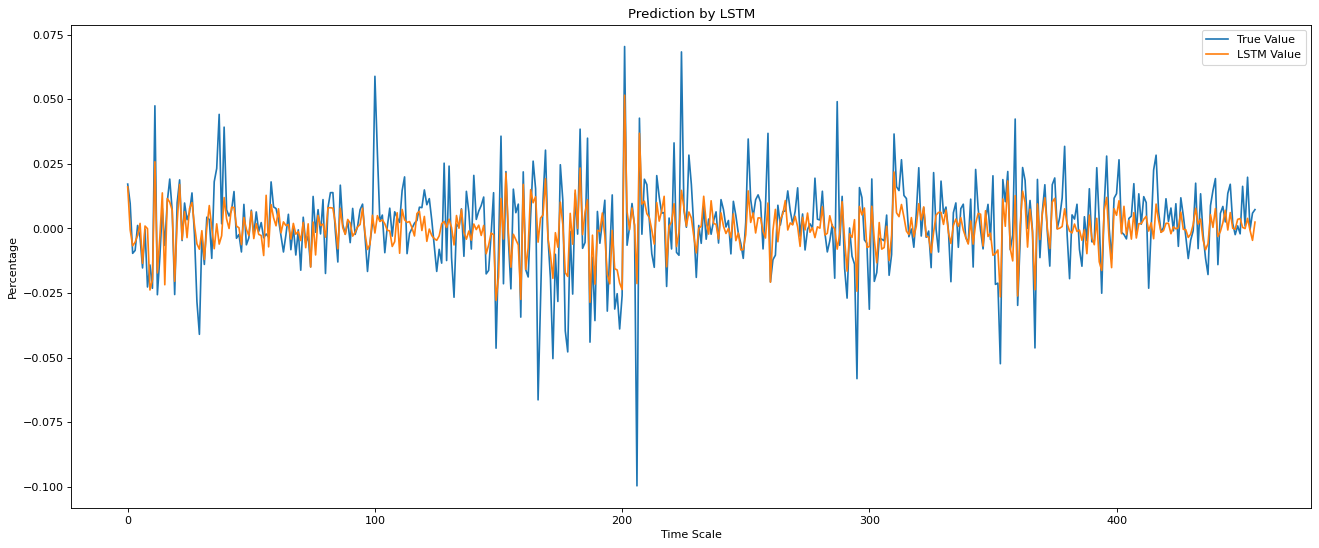

In [ ]:
#Predicted vs True Adj Close Value – LSTM
from matplotlib.pyplot import figure
figure(figsize=(20,8), dpi=80)
plt.plot(y_test, label="True Value")
plt.plot(y_pred, label="LSTM Value")
plt.title("Prediction by LSTM")
plt.xlabel("Time Scale")
plt.ylabel("Percentage")
plt.legend()
plt.show()


In [ ]:
# Accuracy: Calculating RMSE between y_test and y_pred
RMSE_LSTM = 0
for i in range(0,len(y_test),1):
  value = (y_test[i] - y_pred[i])**2
  RMSE_LSTM = RMSE_LSTM + value
print("The mean-square-error of the LSTM model is ", RMSE_LSTM**(0.5))
print("The training time of the mudel is {} seconds.".format(stop - start))

The mean-square-error of the LSTM model is  [0.26827306]
The training time of the mudel is 83.67454641500001 seconds.


In [ ]:
y_pred = lstm.predict(X_train)
RMSE_LSTM = 0
for i in range(0,len(y_train),1):
  value = (y_train[i] - y_pred[i])**2
  RMSE_LSTM = RMSE_LSTM + value
print("The mean-square-error of the LSTM model is ", RMSE_LSTM**(0.5))


The mean-square-error of the LSTM model is  [1.5013784]


In [ ]:
######## Enhance the model with Random Forests ############

# Import libraties
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
import pywt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer


In [ ]:
# Splitting to Training set and Test set
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(df_feature):
  X_train, X_test = df_feature[:len(train_index)], df_feature[len(train_index): (len(train_index)+len(test_index))]
  y_train, y_test = output_var[:len(train_index)], output_var[len(train_index): (len(train_index)+len(test_index))]


In [ ]:
# Enhance the Random Forests Model with Wavelet Smoother
def wavelet_smoother(x_train):
  n = x_train.shape[0]
  wavelet = "db6"
  df_wavelets = x_train.copy()

  for i in x_train.columns:
      signal = x_train[i]
      coefficients = pywt.wavedec(signal, wavelet, mode='per')
      coefficients[1:] = [pywt.threshold(i, value=signal.max(), mode='soft') for i in coefficients[1:]]
      reconstructed_signal = pywt.waverec(coefficients, wavelet, mode='per')
      df_wavelets[i] = reconstructed_signal[:n]

  df_wavelets = df_wavelets.fillna(0)
  return df_wavelets


In [ ]:
# Assemble the Random Forests Model
wavelet_smoother = FunctionTransformer(wavelet_smoother)
pca = PCA()

# determine the numerical features I want to smooth
dfs = X_train[X_train.columns.difference(['VOL','OPEN'])]
numerical_ix = dfs.select_dtypes(include=['float64']).columns

# define the data preparation for the columns
t = [('wav', wavelet_smoother, numerical_ix), ('pca', pca, numerical_ix)]
col_transform = ColumnTransformer(transformers=t, remainder='passthrough')

# Random Forests
rforest = RandomForestRegressor()
pipe = Pipeline([('prep', col_transform), ('rforest', rforest)])

nestimators_rs = [200, 300, 500]
ncomponents_rs = list(range(10, X_test.shape[1]))

#set of parameters for random search
param_grid = [{'prep__pca__n_components':ncomponents_rs, 'rforest__max_depth': nestimators_rs}]

grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, return_train_score=True, n_jobs = -1)
grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters scaling grid: {}".format(best_parameters))
print("Best cross-validation score scaling grid: {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)


Best parameters scaling grid: {'rforest__max_depth': 500, 'prep__pca__n_components': 10}
Best cross-validation score scaling grid: -14.65


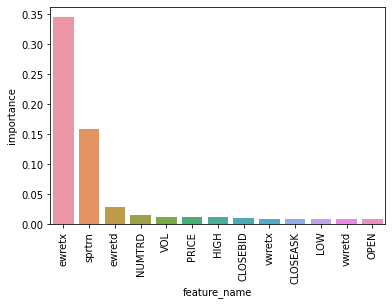

In [ ]:
#plot the importances
importance = pd.DataFrame(zip(best_model[1].feature_importances_, X_train.columns.values.tolist()))
importance.columns = ['importance','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['importance'], data=importance,orient='v',dodge=False,order=importance.sort_values('importance',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
plt.show()


Epoch 1/50
572/572 [==============================] - 3s 3ms/step - loss: 6.4357e-04
Epoch 2/50
572/572 [==============================] - 1s 2ms/step - loss: 5.3844e-04
Epoch 3/50
572/572 [==============================] - 1s 2ms/step - loss: 5.1854e-04
Epoch 4/50
572/572 [==============================] - 1s 2ms/step - loss: 5.1524e-04
Epoch 5/50
572/572 [==============================] - 1s 2ms/step - loss: 5.1332e-04
Epoch 6/50
572/572 [==============================] - 2s 3ms/step - loss: 5.1300e-04
Epoch 7/50
572/572 [==============================] - 2s 3ms/step - loss: 5.1234e-04
Epoch 8/50
572/572 [==============================] - 2s 3ms/step - loss: 5.1141e-04
Epoch 9/50
572/572 [==============================] - 2s 3ms/step - loss: 5.1116e-04
Epoch 10/50
572/572 [==============================] - 1s 2ms/step - loss: 5.1073e-04
Epoch 11/50
572/572 [==============================] - 2s 3ms/step - loss: 5.1006e-04
Epoch 12/50
572/572 [==============================] - 2s 3ms/s

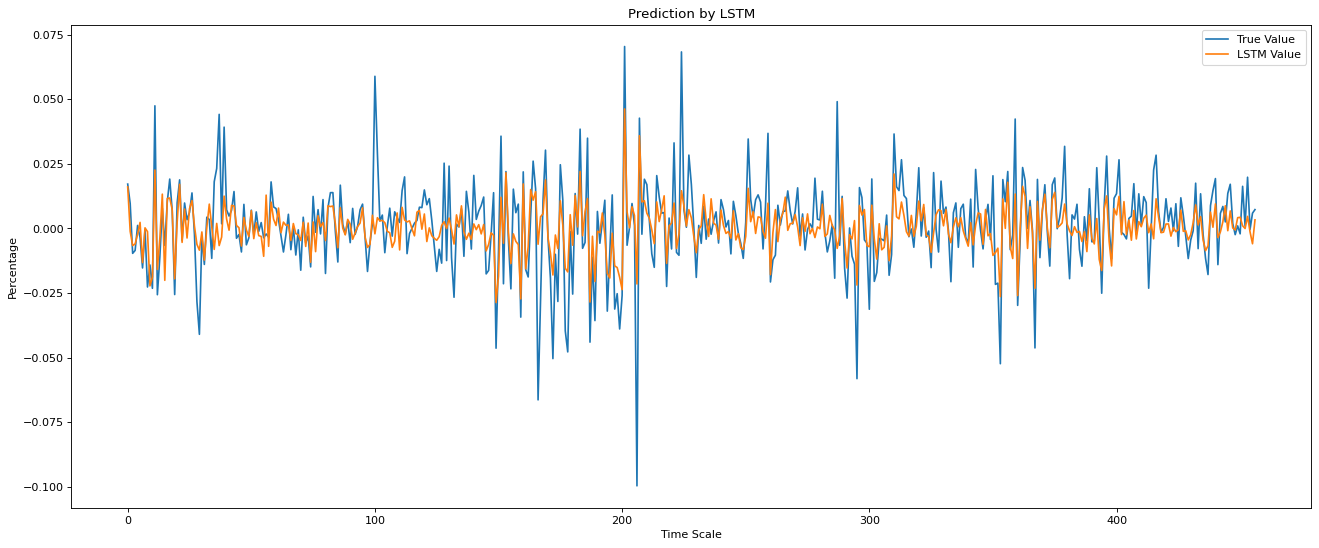

In [ ]:
# The most important features are "ewretx", and "sprtrn"
# Repeat the LSTM model using the selected two features only

selected_features = ['ewretx', 'sprtrn']
df_selectedFea = df[selected_features]

# Set Target Variable
output_var = pd.DataFrame(df['RET'])

# Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df_selectedFea)
feature_transform = pd.DataFrame(columns=selected_features, data=feature_transform, index=df.index)

df_open = df['OPEN']

# Splitting to Training set and Test set
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
  X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
  y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()
  _, X_open_test = df_open[:len(train_index)], df_open[len(train_index): (len(train_index)+len(test_index))]
  _, X_test_all = df_feature[:len(train_index)], df_feature[len(train_index): (len(train_index)+len(test_index))]

# Process the Data for LSTM
train_X = np.array(X_train)
test_X = np.array(X_test)
X_train = train_X.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = test_X.reshape(X_test.shape[0], 1, X_test.shape[1])

# Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, train_X.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

# Model Training
import timeit
start = timeit.default_timer()

history=lstm.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1, shuffle=False)

stop = timeit.default_timer()

# LSTM Prediction
y_pred = lstm.predict(X_test)

#Predicted vs True Adj Close Value – LSTM
from matplotlib.pyplot import figure
figure(figsize=(20,8), dpi=80)
plt.plot(y_test, label="True Value")
plt.plot(y_pred, label="LSTM Value")
plt.title("Prediction by LSTM")
plt.xlabel("Time Scale")
plt.ylabel("Percentage")
plt.legend()
plt.show()


In [ ]:
# Accuracy: Calculating MSE of y_test and y_pred
RMSE_LSTM_RF = 0
for i in range(0,len(y_test),1):
  value = (y_test[i] - y_pred[i])**2
  RMSE_LSTM_RF = RMSE_LSTM_RF + value
print("The mean-square-error of teh LSTM model is ", RMSE_LSTM_RF**(0.5))
print("The training time of the mudel is {} seconds.".format(stop - start))


The mean-square-error of teh LSTM model is  [0.26840898]
The training time of the mudel is 83.34836784699996 seconds.


In [ ]:
# Accuracy: Calculating MSE of y_train and y_pred
y_pred = lstm.predict(X_train)

RMSE_LSTM_RF = 0
for i in range(0,len(y_train),1):
  value = (y_train[i] - y_pred[i])**2
  RMSE_LSTM_RF = RMSE_LSTM_RF + value
print("The mean-square-error of the LSTM model is ", RMSE_LSTM_RF**(0.5))


The mean-square-error of teh LSTM model is  [1.5125419]


In [ ]:
####### White Reality Check #######
#returns must be detrended by subtracting the average daily return of the benchmark

def bootstrap(ser):
  ser.dropna(inplace=True)
  arr = np.array(ser.values)
  alpha = .05*100 #significance alpha
  reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

  percentile = 100-alpha
  ave = np.average(arr) #arithmetic mean

  print("average return %f" %ave)

  #ave = ms.gmean(arr) #geometric mean

  centered_arr = arr-ave
  n = len(centered_arr)
  #constructs 50000 alternative return histories and calculates their theoretical averages
  xb = np.random.choice(centered_arr, (n, reps), replace=True)
  mb = xb.mean(axis=0) #arithmetic mean
  #mb = ms.gmean(mb, axis=0) #geometric mean

  #sorts the 50000 averages
  mb.sort()
  #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
  print(np.percentile(mb, [2.5, 97.5]))
  threshold = np.percentile(mb, [percentile])[0]

  if ave > threshold:
      print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
  else:
      print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

  #count will be the items i that are smaller than ave
  count_vals = 0
  for i in mb:
      count_vals += 1
      if i > ave:
          break

  #p is based on the count that are larger than ave so 1-count is needed:
  p = 1-count_vals/len(mb)

  print("p_value:")
  print(p)

  #histogram
  sr = pd.Series(mb)
  desc = sr.describe()
  count = desc[0]
  std = desc[2]
  minim = desc[3]
  maxim = desc[7]
  R = maxim-minim
  n = count
  s = std
  bins = int(round(R*(n**(1/3))/(3.49*std),0))
  fig = sr.hist(bins=bins)
  # plt.show()

  #about the histogram
  #https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram
  #R(n^(1/3))/(3.49σ)
  #R is the range of data (in your case R = 3-(-3)= 6),
  #n is the number of samples,
  #σ is your standard deviation.


In [ ]:
# Detrended Price

import statsmodels.api as sm

def detrendPrice(series):
  # fit linear model
  length = len(series)
  x = np.arange(length)
  #y = np.array(series.values)
  y = np.array(series)
  x_const = sm.add_constant(x) #need to add intercept constant
  model = sm.OLS(y,x_const)
  result = model.fit()
  #y = pd.Series(y)
  #intercept = result.params[0]
  #beta = result.params[1]
  #print(result.summary())
  df = pd.DataFrame(result.params*x_const)
  y_hat = df[0] + df[1]
  #the residuals are the detrended prices
  resid = y-y_hat
  #add minimum necessary to residuals to avoid negative detrended prices
  resid = resid + abs(resid.min() + 1/10*resid.min())
  return resid

average return 0.028145
[-0.0078501   0.00802315]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.0


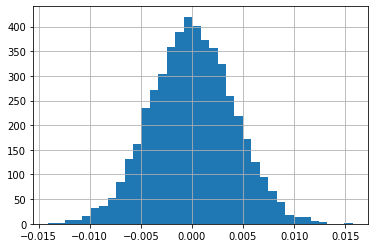

In [ ]:
# White Reality Check - Adopted from APS 1052

openp = X_open_test.values.tolist()
detrended_open = detrendPrice(openp)
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)

test_X_all = np.array(X_test_all)

positions2 = np.where(best_model.predict(X_test_all) > 0,1,-1 )
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
bootstrap(detrended_syst_rets)
plt.show()

Saving AAPL_price.csv to AAPL_price.csv


Saving AAPL_PutCallStrike.csv to AAPL_PutCallStrike.csv


Saving YieldCurve.csv to YieldCurve.csv


Saving AAPL_OptionVolume.csv to AAPL_OptionVolume.csv


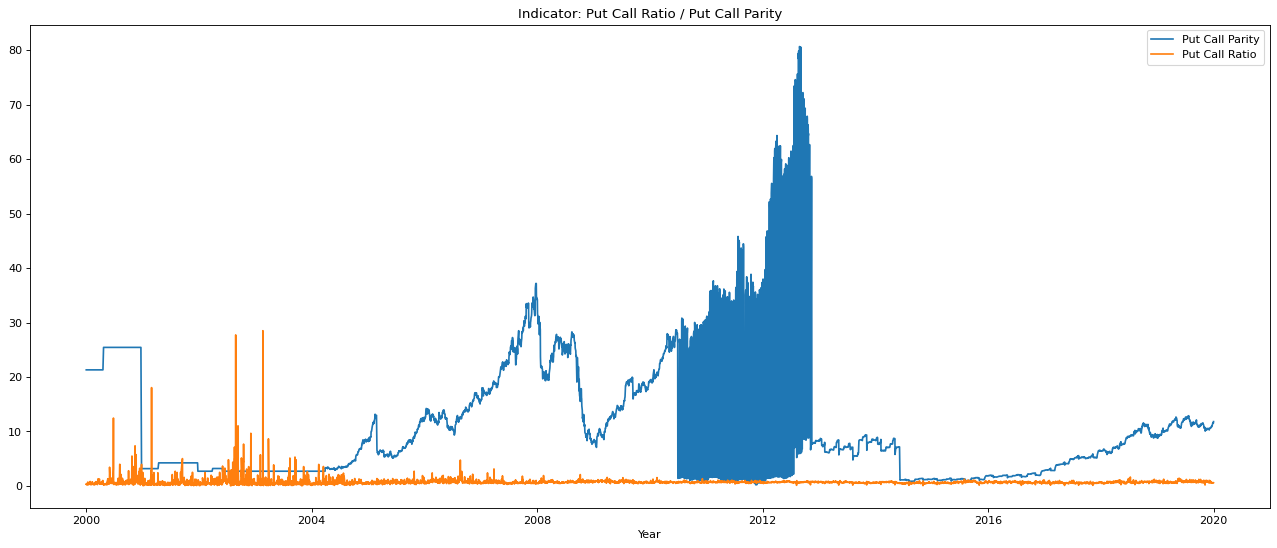

In [ ]:
# Put-Call Ratio & Put-Call Parity
uploaded = files.upload()
price = pd.read_csv(io.BytesIO(uploaded['AAPL_price.csv']), index_col=['date'], parse_dates=True)

uploaded = files.upload()
other = pd.read_csv(io.BytesIO(uploaded['AAPL_PutCallStrike.csv']), index_col=['date'], parse_dates=True)
#other = pd.read_csv("AAPL_PutCallStrike.csv", index_col=['date'], parse_dates=True)

df1 =  pd.pivot_table(other,values='strike_price',index='date',columns=['cp_flag'])
df1.index.name = "date"
df1.rename(columns={"C": "C_strike_price", "P": "P_strike_price"}, inplace=True)
df1["option_days"]=other.days[0]
df1 = price.join(df1)

uploaded = files.upload()
yc = pd.read_csv(io.BytesIO(uploaded['YieldCurve.csv']), index_col=['date'], parse_dates=True)
#yc= pd.read_csv("YieldCurve.csv", index_col=['date'], parse_dates=True)
yc.index.name = "date"
yc = yc[yc["days"]==7]
yc.drop(["days"], axis=1, inplace=True)
df1 = df1.join(yc)

df1["daily_rate"]=df1.rate/365
df1["PV_strike_price"] = df1.C_strike_price/np.exp(df1.daily_rate*df1.option_days)
df1["PutCallParity"] = df1.PRICE - df1.PV_strike_price
df1.fillna(method = "ffill", inplace=True)
#df1.PutCallParity.plot()

uploaded = files.upload()
vol = pd.read_csv(io.BytesIO(uploaded['AAPL_OptionVolume.csv']), index_col=['date'], parse_dates=True)
#vol = pd.read_csv("AAPL_OptionVolume.csv", index_col=['date'], parse_dates=True)
vol.index.name="date"
df_unstacked_vol =  pd.pivot_table(vol,values='volume',index='date',columns=['cp_flag'])
df_unstacked_vol.index.name="date"

df_unstacked_vol["PutCallRatio"] = df_unstacked_vol.P/df_unstacked_vol.C
df_unstacked_vol.drop(["C","P"], axis=1, inplace=True)
df1=df1.join(df_unstacked_vol)
df1.fillna(method = "ffill", inplace=True)
#df1.PutCallRatio.plot()

figure(figsize=(20,8), dpi=80)
plt.plot(df1.index, df1.PutCallParity, label="Put Call Parity")
plt.plot(df1.index, df1.PutCallRatio, label="Put Call Ratio")
plt.title("Indicator: Put Call Ratio / Put Call Parity")
plt.xlabel("Year")
plt.legend()
plt.show()
